In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *

from joblib import Parallel, delayed
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from tqdm_joblib import tqdm_joblib

np.set_printoptions(linewidth=120)

/home/hxcai/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
pred = np.load(f'outputs/Sei_pred_crop_4096_zero.npy')
print(pred.shape)
print(pred.mean())

target = np.load('../data/Sei/sei_chr8_dataset_label.npy')
print(target.shape)
print(target.mean())

(10000, 21907)
0.005537783
(10000, 21907)
0.004913534486693751


In [3]:
def compute_classification_metrics(target, pred):
    # 如果标签包括0和1
    if np.any(target==0) and np.any(target==1):
        report = classification_report(target, pred > 0.5, labels=[0, 1], output_dict=True, zero_division=0)
        return np.array([
            report['1']['support'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score'],
            roc_auc_score(target, pred, labels=[0,1]),
            average_precision_score(target, pred)
        ])
    else:  # 全是 0，返回 NaNs
        return np.full(6, np.nan)


def compute_metrics_for_each_column_parallel(target, pred, n_jobs=-1):  # -1 使用所有 CPU 核
    num_columns = target.shape[1]
    with tqdm_joblib(tqdm(total=num_columns)) as progress_bar:
        results = Parallel(n_jobs=n_jobs)(
            delayed(compute_classification_metrics)(target[:, i], pred[:, i]) for i in range(num_columns)
        )
    return np.vstack(results)

In [4]:
# sei
target = np.load('../data/Sei/sei_chr8_dataset_label.npy')
print(target.shape)

length_list = np.array([8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])

(10000, 21907)


In [5]:
# pad zero
pred_list = []
score_list = []
for cropped_length in length_list:
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_zero.npy')
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_N.npy')
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_random.npy')
    # pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_genome.npy')
    pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_repeat.npy')
    pred_list.append(pred)
    score = compute_metrics_for_each_column_parallel(target, pred)
    score_list.append(score)
pred_list = np.stack(pred_list)
score_list = np.stack(score_list)

np.save('Sei_score_zero.npy', score_list)
np.save('Sei_score_N', score_list)
np.save('Sei_score_random.npy', score_list)
np.save('Sei_score_genome.npy', score_list)
np.save('Sei_score_repeat.npy', score_list)

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

  0%|          | 0/21907 [00:00<?, ?it/s]

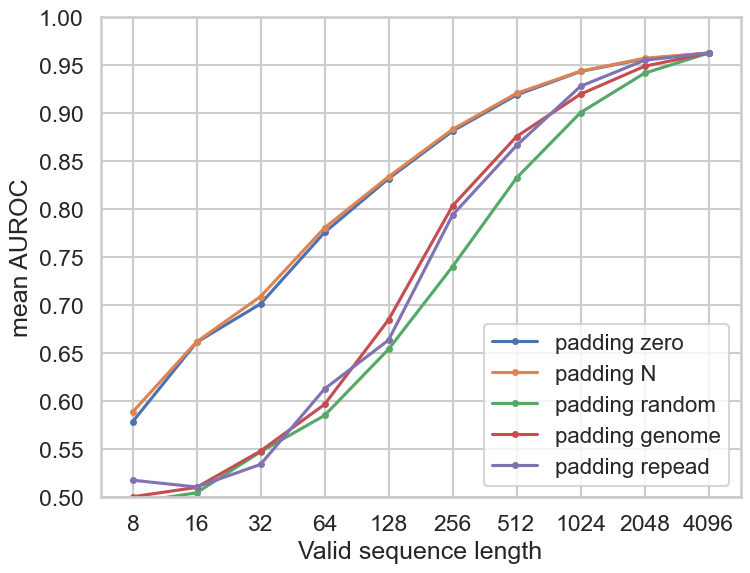

In [9]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)
positions = np.log2(length_list)

score_list = np.load('Sei_score_zero.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding zero')

score_list = np.load('Sei_score_N.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding N')

score_list = np.load('Sei_score_random.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding random')

score_list = np.load('Sei_score_genome.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding genome')

score_list = np.load('Sei_score_repeat.npy')
data = np.nanmean(score_list[:, :, 4], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding repead')


plt.xlim(np.min(positions)-0.5, np.max(positions)+0.5)
plt.ylim(0.5, 1.0)
plt.xticks(positions, labels=length_list)
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.xlabel('Valid sequence length')
plt.ylabel('mean AUROC')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/sei_padding_AUROC_line.png', dpi=400)
plt.show()

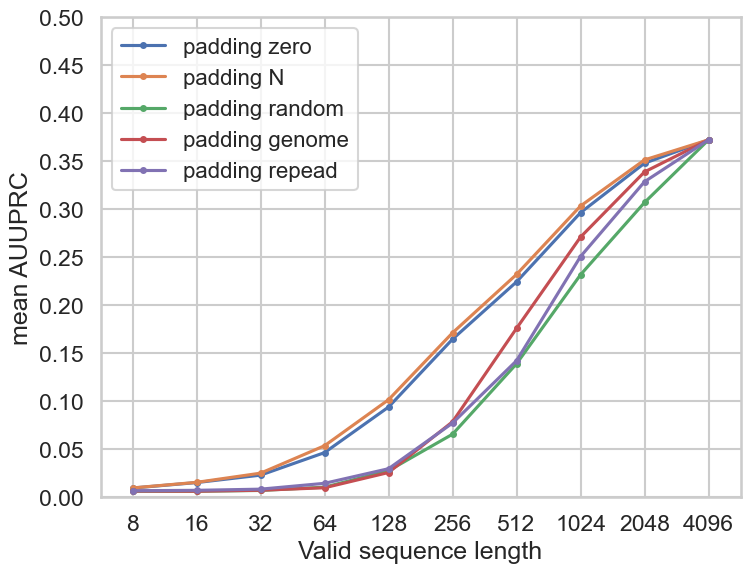

In [12]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)
positions = np.log2(length_list)

score_list = np.load('Sei_score_zero.npy')
data = np.nanmean(score_list[:, :, 5], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding zero')

score_list = np.load('Sei_score_N.npy')
data = np.nanmean(score_list[:, :, 5], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding N')

score_list = np.load('Sei_score_random.npy')
data = np.nanmean(score_list[:, :, 5], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding random')

score_list = np.load('Sei_score_genome.npy')
data = np.nanmean(score_list[:, :, 5], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding genome')

score_list = np.load('Sei_score_repeat.npy')
data = np.nanmean(score_list[:, :, 5], axis=1)
plt.plot(positions, data, marker="o", markersize=4, label='padding repead')


plt.xlim(np.min(positions)-0.5, np.max(positions)+0.5)
plt.ylim(0.0, 0.5)
plt.xticks(positions, labels=length_list)
plt.yticks(np.arange(0.0, 0.51, 0.05))
plt.xlabel('Valid sequence length')
plt.ylabel('mean AUUPRC')
plt.legend(fontsize=16, loc='upper left')
plt.savefig('figures/sei_padding_AUPRC_line.png', dpi=400)
plt.show()

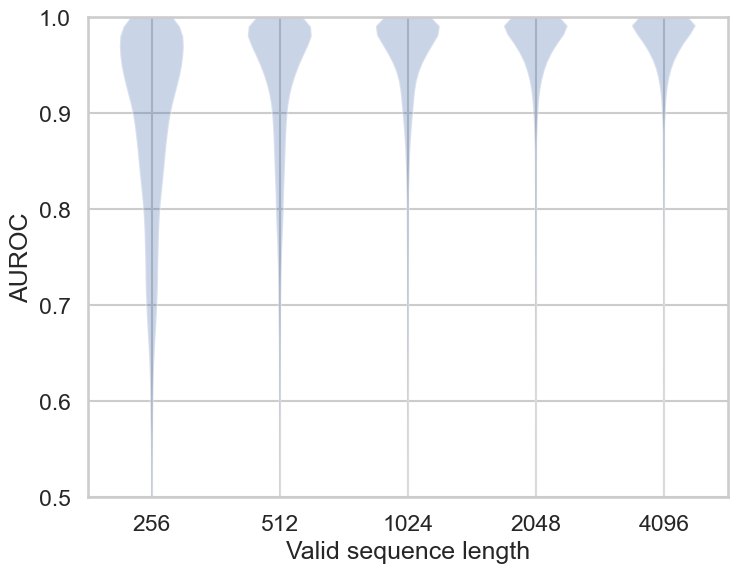

In [75]:
length_list = np.array([256, 512, 1024, 2048, 4096])
# score_list.shape: (num_lengths, num_tasks, metrics)
AUROC_data = score_list[:, :, 4]
AUROC_data = AUROC_data[:, ~np.isnan(AUROC_data).any(axis=0)]


positions = np.log2(length_list)

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

plt.violinplot(
    [AUROC_data[i, :] for i in range(len(length_list))],
    positions=positions,
    showextrema=False,
)

plt.xlim(7.5, 12.5)
plt.ylim(0.5, 1.0)
plt.xticks(positions, length_list)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel('Valid sequence length')
plt.ylabel('AUROC')

plt.savefig('figures/Sei_padding_AUROC_boxplot.png', dpi=400)
plt.show()

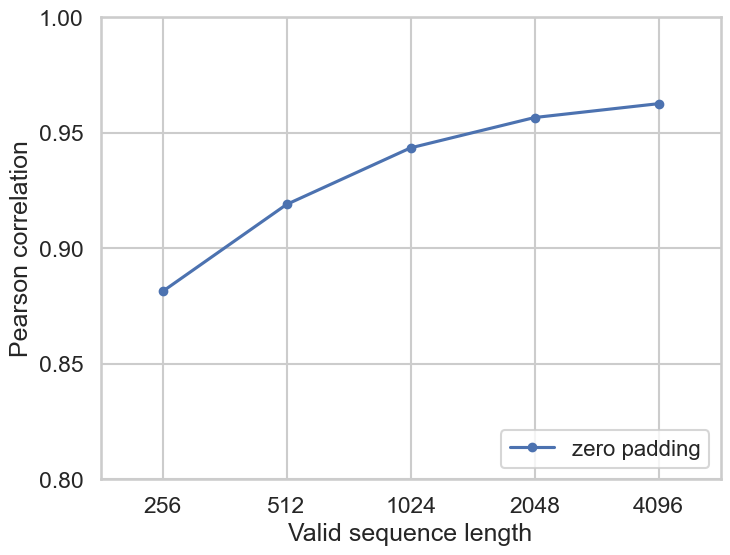

In [52]:
AUROC_list = np.nanmean(score_list[:, :, 4], axis=1)
AUPRC_list = np.nanmean(score_list[:, :, 5], axis=1)
plt.plot(np.log2(length_list), AUROC_list, marker="o", markersize=6, label='zero padding')
# plt.plot(np.log2(length_list), AUPRC_list, marker="o", markersize=6, label='zero padding')




# # pad N
# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Sei_pred_crop_{cropped_length}_N.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='N padding')


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
#     # print(pred.shape)
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# pred_list = pred_list.mean(1)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding')


plt.xlim(7.5, 12.5)
plt.ylim(0.8, 1.0)
plt.xticks([8, 9, 10, 11, 12], labels=[256, 512, 1024, 2048, 4096])
plt.yticks([0.8, 0.85, 0.9, 0.95, 1.0])
plt.xlabel('Valid sequence length')
plt.ylabel('AUROC (across samples)')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_between_3_padding_methods.png', dpi=400)
plt.savefig('figures/correlation_between_3_padding_methods.pdf', dpi=400)
plt.show()

[0.14831763 0.2190007  0.32825761 0.42501433 0.50697009 0.67599033 0.73477368 0.73628863 0.73806766 0.73806766]
[0.14961445 0.21899548 0.32970724 0.42660532 0.50855883 0.67742352 0.73501291 0.73659921 0.73806766 0.73806766]


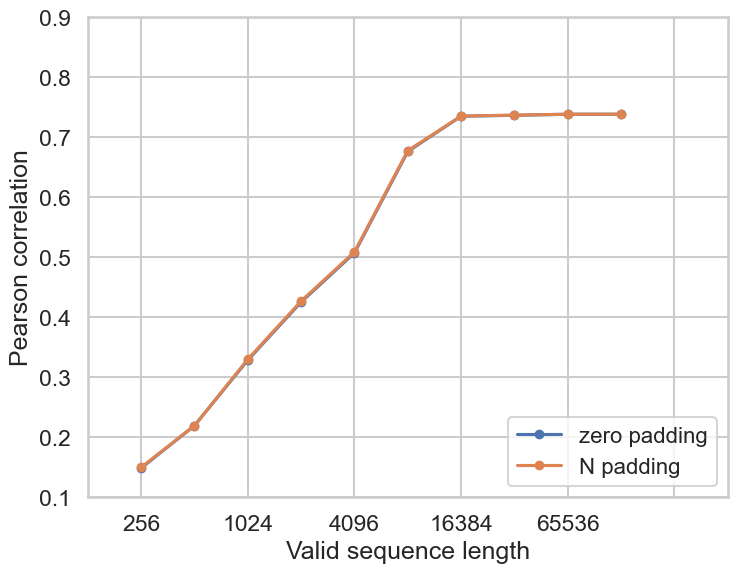

In [9]:
# # basenji2

# plt.figure(figsize=(8, 6), dpi=100)
# plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

# length_list = np.array([256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072])
# target = np.load('data/enformer_targets_test_center_2.npy')
# # print(target.shape)


# # pred_list = []
# # for cropped_length in length_list:
# #     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}.npy')
# #     pred_list.append(pred)
# # pred_list = np.stack(pred_list)
# # corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# # corr = corr[-1, :-1]
# # plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='w/o padding')


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_zero.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# print(corr)
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='zero padding')


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_N.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# print(corr)
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='N padding')



# # pred_list = []
# # for cropped_length in length_list:
# #     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_random_5_times.npy')
# #     # print(pred.shape)
# #     pred_list.append(pred)
# # pred_list = np.stack(pred_list)
# # pred_list = pred_list.mean(1)
# # corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# # corr = corr[-1, :-1]
# # plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding')





# plt.xlim(7, 19)
# plt.ylim(0.1, 0.9)
# plt.xticks([8, 10, 12, 14, 16, 18], labels=[256, 1024, 4096, 16384, 65536, ''])
# plt.yticks(0.1 * np.arange(1, 10))
# plt.xlabel('Valid sequence length')
# plt.ylabel('Pearson correlation')
# plt.legend(fontsize=16, loc='lower right')
# plt.savefig('figures/correlation_between_3_padding_methods.png', dpi=400)
# plt.savefig('figures/correlation_between_3_padding_methods.pdf', dpi=400)
# plt.show()

(11, 5, 1937, 2, 5313)
(11, 5, 1937, 2, 5313)


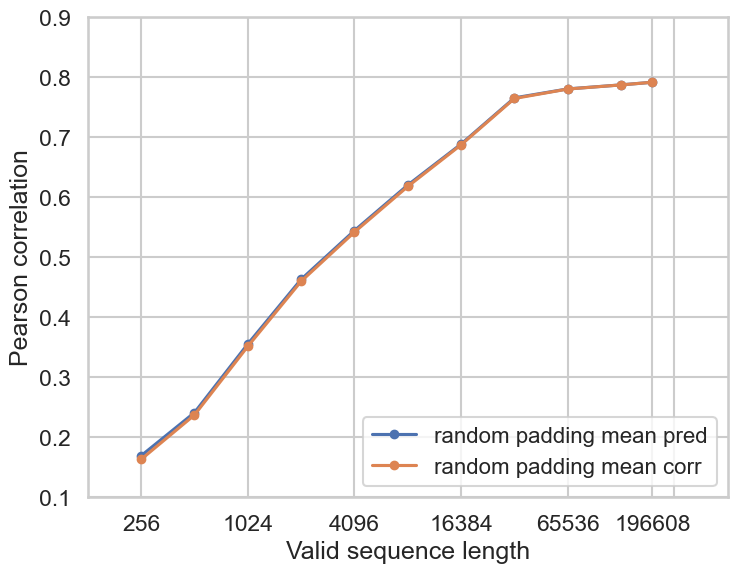

In [4]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)




pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
pred_list = pred_list.mean(1)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean pred')



pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1].reshape(-1, 5).mean(1)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean corr')




plt.xlim(7, 19)
plt.ylim(0.1, 0.9)
plt.xticks([8, 10, 12, 14, 16, 16+np.log2(3), 18], labels=[256, 1024, 4096, 16384, 65536, 196608, ''])
plt.yticks(0.1 * np.arange(1, 10))
plt.xlabel('Valid sequence length')
plt.ylabel('Pearson correlation')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_random_mean.png', dpi=400)
plt.show()

In [5]:
pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))

print(corr)

(11, 5, 1937, 2, 5313)
[[1.         0.91465899 0.91662061 ... 0.16742964 0.16742964 0.16327258]
 [0.91465899 1.         0.91243314 ... 0.16608902 0.16608902 0.16096631]
 [0.91662061 0.91243314 1.         ... 0.16871918 0.16871918 0.16371049]
 ...
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16327258 0.16096631 0.16371049 ... 0.79138096 0.79138096 1.        ]]
